# Error Rate Ratio

### Dataset
Using adult income dataset from UCI repo provided by shap library.

### Definition
Measures the ratio in errors per attribute by overall error.

The 2-sided version of error ratio can be written as :

ratio <= error(A=a) / total_error <= 1/ratio

Mathematically:
$ratio <= \frac{E[abs(h(x) - y)| A = a]}{E[abs(h(x) - y)]} <= \frac{1}{ratio}, \forall\ a $


In [1]:
import numpy as np
import pandas as pd

import shap
shap.initjs()

from fairlearn.reductions import ExponentiatedGradient
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

In [2]:
X, Y = shap.datasets.adult()
sensitive_attribute = 'Sex'

A = X[sensitive_attribute]
X = pd.get_dummies(X)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

le = LabelEncoder()
Y = le.fit_transform(Y)

X = X.reset_index(drop=True)
A = A.reset_index(drop=True)

In [3]:
# class LeastSquaresBinaryClassifierLearner:
#     def __init__(self):
#         self.weights = None

#     def fit(self, X, Y, sample_weight):
#         sqrtW = np.sqrt(sample_weight)
#         matX = np.array(X) * sqrtW[:, np.newaxis]
#         vecY = Y * sqrtW
#         self.lsqinfo = np.linalg.lstsq(matX, vecY, rcond=-1)
#         self.weights = pd.Series(self.lsqinfo[0], index=list(X))

#     def predict(self, X):
#         pred = X.dot(np.asarray(self.weights))
#         return 1 * (pred > 0.5)

In [4]:
#unmitigated_predictor = LeastSquaresBinaryClassifierLearner()
#unmitigated_predictor.fit(X, Y, sample_weight=[1])
from sklearn.ensemble import GradientBoostingClassifier
unmitigated_predictor = GradientBoostingClassifier()
unmitigated_predictor.fit(X,Y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [5]:
from fairlearn.reductions import ErrorRateRatio, ErrorRate

def Unmit(X): return unmitigated_predictor.predict(X)
# violation
disparity_moment = ErrorRateRatio()
disparity_moment.load_data(X, Y, sensitive_features=A)
er_violation_unmitigated = disparity_moment.gamma(Unmit).max()

# error
error = ErrorRate()
error.load_data(X, Y, sensitive_features=A)
er_error_unmitigated = error.gamma(Unmit)[0]

# Experiment 1 - Calculating violation by varying epsilon 

In [6]:
# Experiment 1 - Calculating violation by varying epsilon 
from fairlearn.reductions import ErrorRate, ErrorRateRatio

eps_list = [0.005, 0.01, 0.05, 0.1]
er_expgrad_error = []
er_expgrad_violation = []
er_best_gap = []

estimator = GradientBoostingClassifier()

for eps in eps_list:
    expgrad_X = ExponentiatedGradient(estimator,
                                      constraints=ErrorRateRatio(),
                                      eps=eps, nu=1e-6)
    
    expgrad_X.fit(X, Y, sensitive_features=A)
    
    def Q(X): return expgrad_X._pmf_predict(X)[:, 1]
    # violation
    disparity_moment = ErrorRateRatio()
    disparity_moment.load_data(X, Y, sensitive_features=A)
    disparity = disparity_moment.gamma(Q).max()
    
    # error
    error = ErrorRate()
    error.load_data(X, Y, sensitive_features=A)
    error = error.gamma(Q)[0]
    
    er_expgrad_violation.append(disparity)
    er_expgrad_error.append(error)
    er_best_gap.append(expgrad_X._best_gap)

In [7]:
print('{}\t\t{}\t\t\t{}\t\t\t{}'.format('Epsilon', 'Max Violation', 'Error', 'Best Gap'))
for i in range(len(eps_list)):
    print('{}\t\t{}\t\t{}\t{}'.format(eps_list[i], er_expgrad_violation[i],
                                  er_expgrad_error[i], er_best_gap[i]))
print('{}\t\t{}\t\t{}\t{}'.format('Unmit.', er_violation_unmitigated,
                              er_error_unmitigated, '-'))

Epsilon		Max Violation			Error			Best Gap
0.005		0.004999999999984767		0.15849697893180906	2.220446049250313e-16
0.01		0.010000000000026682		0.15797567691601994	6.661338147750939e-16
0.05		0.05000000000002458		0.1366009346668869	2.7755575615628914e-17
0.1		0.06581698492555473		0.13006357298608764	0.0
Unmit.		0.06770029155136431		0.13064709314824483	-


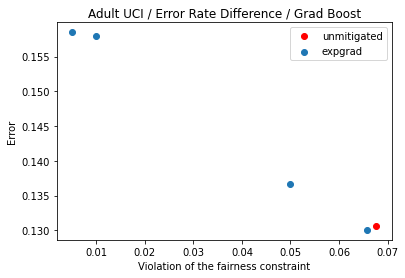

In [8]:
import matplotlib.pyplot as plt

plt.scatter(er_expgrad_violation, er_expgrad_error, label="expgrad")
plt.plot(er_violation_unmitigated, er_error_unmitigated, 'ro', label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult UCI / Error Rate Difference / Grad Boost')
plt.legend()
plt.show()

# Experiment 2 - Calculating violation by varying epsilon and ratio

In [9]:
# Experiment 2 - Calculating violation by varying epsilon 
from fairlearn.reductions import ErrorRateRatio

ratio_list = [0.8, 0.85, 0.9, 0.95, 1.0]
eps_list = [0.005, 0.01, 0.05, 0.1]

ratio_to_violation = {}
ratio_to_error = {}
ratio_to_unmitigated_er_violation = {}
ratio_to_best_gap = {}
for ratio in ratio_list:
    er_expgrad_error = []
    er_expgrad_violation = []
    er_best_gap = []
    estimator = GradientBoostingClassifier()

    for eps in eps_list:
        expgrad_X = ExponentiatedGradient(estimator,
                                          constraints=ErrorRateRatio(ratio=ratio),
                                          eps=eps, nu=1e-6)

        expgrad_X.fit(X, Y, sensitive_features=A)

        def Q(X): return expgrad_X._pmf_predict(X)[:, 1]
        # violation
        disparity_moment = ErrorRateRatio(ratio=ratio)
        disparity_moment.load_data(X, Y, sensitive_features=A)
        disparity = disparity_moment.gamma(Q).max()

        # error
        error = ErrorRate()
        error.load_data(X, Y, sensitive_features=A)
        error = error.gamma(Q)[0]

        er_expgrad_violation.append(disparity)
        er_expgrad_error.append(error)
        er_best_gap.append(expgrad_X._best_gap)
    
    ratio_to_violation[ratio] = er_expgrad_violation
    ratio_to_error[ratio] = er_expgrad_error
    ratio_to_best_gap[ratio] = er_best_gap
    
    # Unmit.
    def Unmit(X): return unmitigated_predictor.predict(X)
    # violation
    disparity_moment = ErrorRateRatio(ratio=ratio)
    disparity_moment.load_data(X, Y, sensitive_features=A)
    er_violation_unmitigated = disparity_moment.gamma(Unmit).max()
    ratio_to_unmitigated_er_violation[ratio] = er_violation_unmitigated
    
# error of unmit.
error = ErrorRate()
error.load_data(X, Y, sensitive_features=A)
er_error_unmitigated = error.gamma(Unmit)[0]

The pivot operation produces a pivot value of: 2.6e-07, which is only slightly greater than the specified tolerance 1.0e-09. This may lead to issues regarding the numerical stability of the simplex method. Removing redundant constraints, changing the pivot strategy via Bland's rule or increasing the tolerance may help reduce the issue.


In [10]:
for ratio in ratio_list:
    print('Ratio: {}'.format(ratio))
    er_expgrad_violation = ratio_to_violation[ratio]
    er_expgrad_error = ratio_to_error[ratio]
    er_best_gap = ratio_to_best_gap[ratio]
    print('{}\t\t{}\t\t\t{}\t\t\t{}'.format('Epsilon', 'Max Violation', 'Error', 'Best Gap'))
    for i in range(len(eps_list)):
        print('{}\t\t{}\t\t{}\t{}'.format(eps_list[i], er_expgrad_violation[i],
                                      er_expgrad_error[i], er_best_gap[i]))

    print('{}\t\t{}\t\t{}\t{}'.format('Unmit.', ratio_to_unmitigated_er_violation[ratio],
                                  er_error_unmitigated, '-'))

Ratio: 0.8
Epsilon		Max Violation			Error			Best Gap
0.005		0.005000000000014576		0.14483541132374128	1.4710455076283324e-14
0.01		0.010000000000008127		0.14257330145705843	4.8960835385969403e-14
0.05		0.04157087292171535		0.13064709314824483	0.0
0.1		0.04157087292171535		0.13064709314824483	0.0
Unmit.		0.04157087292171535		0.13064709314824483	-
Ratio: 0.85
Epsilon		Max Violation			Error			Best Gap
0.005		0.005000000000007068		0.1481875771270876	5.551115123125783e-17
0.01		0.01000000000002059		0.14587311150523447	2.525757381022231e-14
0.05		0.04810322757912758		0.13064709314824483	0.0
0.1		0.04810322757912758		0.13064709314824483	0.0
Unmit.		0.04810322757912758		0.13064709314824483	-
Ratio: 0.9
Epsilon		Max Violation			Error			Best Gap
0.005		0.005000000000040972		0.15169858881401685	1.9201862322404395e-12
0.01		0.010000000000021311		0.14932949389830058	7.882583474838611e-15
0.05		0.04999999999999999		0.1310121365947111	5.578870698741412e-15
0.1		0.05463558223653983		0.1306470931482448

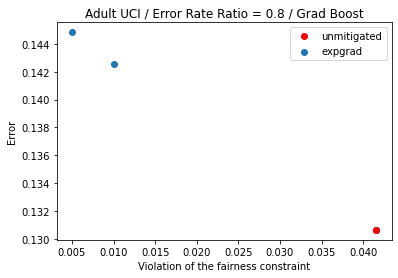

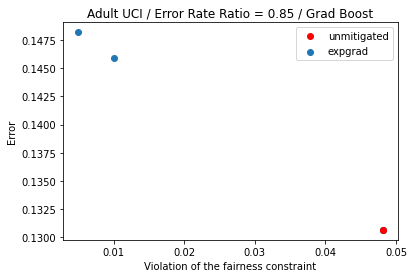

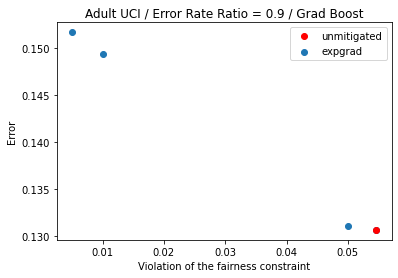

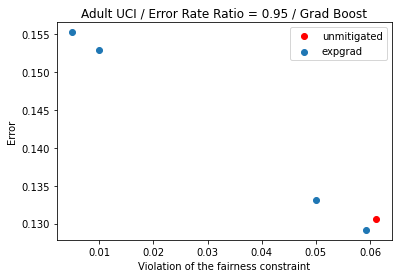

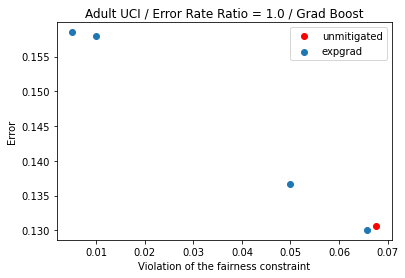

In [11]:
import matplotlib.pyplot as plt

for ratio in ratio_list:
    er_expgrad_violation = ratio_to_violation[ratio]
    expgrad_error = ratio_to_error[ratio]
    
    plt.scatter(er_expgrad_violation, expgrad_error, label="expgrad")
    plt.plot([ratio_to_unmitigated_er_violation[ratio]], er_error_unmitigated, 'ro',
             label="unmitigated")
    plt.xlabel('Violation of the fairness constraint')
    plt.ylabel('Error')
    plt.title('Adult UCI / Error Rate Ratio = {} / Grad Boost'.format(ratio))
    plt.legend()
    plt.show()